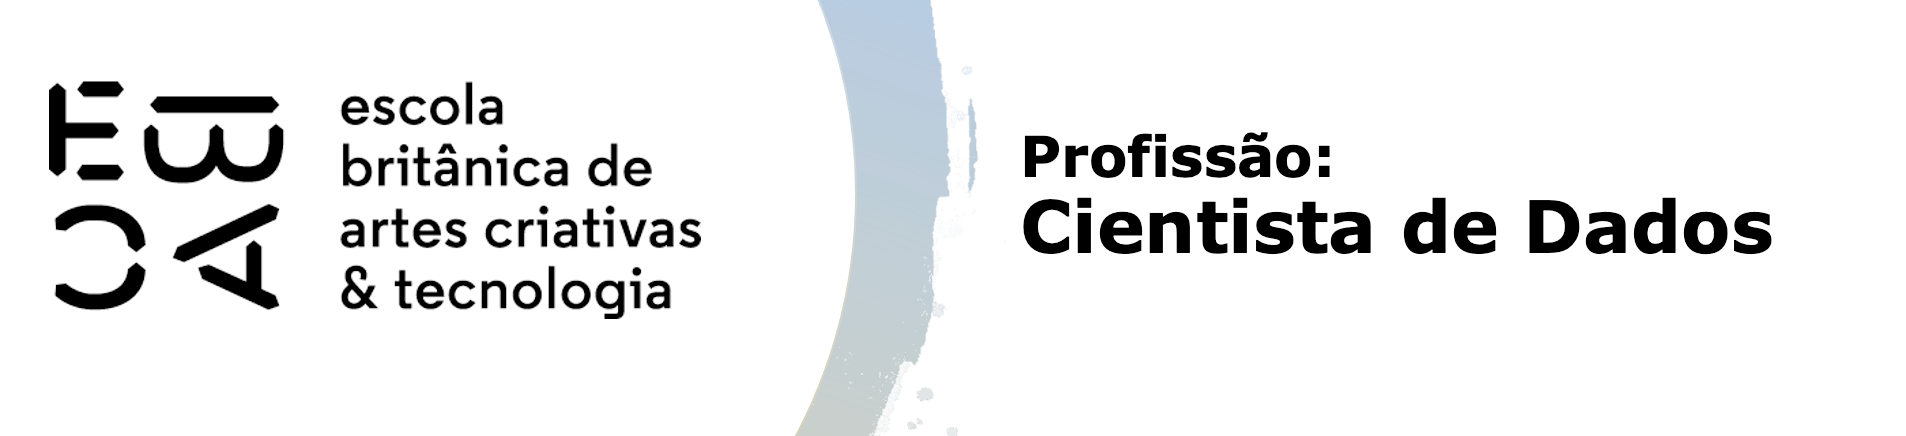

# Regressão III - Tarefa

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api  as sm
import statsmodels.formula.api as smf
import patsy
import warnings;   warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


In [111]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
data_ref                                                              
2015-01-01   5762    M                S               N           0   
2015-01-01   1279    M                S               N           0   
2015-01-01  14111    M                S               N           0   
2015-01-01   8189    M                N               S           2   
2015-01-01   1830    F                N               S           2   

             tipo_renda             educacao estado_civil tipo_residencia  \
data_ref                                                                    
2015-01-01   Empresário    Superior completo       Casado            Casa   
2015-01-01  Assalariado  Superior incompleto       Casado            Casa   
2015-01-01  Assalariado    Superior completo       Casado            Casa   
2015-01-01  Assalariado                Médio       Casado            Casa   
2015-01-01  Assalariado    Superior completo       Casado            Casa   

            idade  tempo_emprego  qt_pessoas_residencia     renda  
data_ref                                                           
2015-01-01     47      16.717808                    2.0  11138.14  
2015-01-01     30       9.600000                    2.0   2424.81  
2015-01-01     28       8.208219                    2.0  13749.66  
2015-01-01     44       1.301370                    4.0   2361.84  
2015-01-01     33       1.254795                    4.0    790.78

## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [112]:
df.isnull().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [113]:
df['tempo_emprego_mean'] = df['tempo_emprego'].fillna(value=df['tempo_emprego'].mean())
df.isna().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
tempo_emprego_mean            0
dtype: int64

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [114]:
# Transformando em datetime
df.index = pd.to_datetime(df.index)

# Ordenando o DataFrame pelo índice de data
df = df.sort_index()

# Definindo o ponto de corte para os três últimos meses
cutoff_date = df.index.max() - pd.DateOffset(months=3)

# Separando a base holdout (os três últimos meses)
df_holdout = df[df.index > cutoff_date]

# Extrair os nomes dos meses do holdout
meses_holdout = df_holdout.index.to_period('M').unique().astype(str).tolist()

meses_holdout

['2016-01', '2016-02', '2016-03']

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [115]:
df_train = df[~df.index.isin(df_holdout.index)].copy()

modelo = smf.ols(formula='np.log(renda) ~ tempo_emprego_mean', data=df_train).fit()
modelo.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                 4.298e+05
Date:                Mon, 12 Aug 2024   Prob (F-statistic):               0.00
Time:                        09:32:13   Log-Likelihood:            -8.0817e+05
No. Observations:              600000   AIC:                         1.616e+06
Df Residuals:                  599998   BIC:                         1.616e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.2780      0.002   4262.716      0.000       8.274       8.282
tempo_emprego_mean     0.1292      0.000    655.629      0.000       0.129       0.130
==============================================================================
Omnibus:                      798.953   Durbin-Watson:                   1.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              717.227
Skew:                          -0.046   Prob(JB):                    1.80e-156
Kurtosis:                       2.857   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
print(f'O R² ajustado é: {modelo.rsquared_adj:.2%}')

O R² ajustado é: 41.74%


Um R² ajustado de 41.74% indica que o modelo tem uma capacidade moderada a alta de explicar a variabilidade nos dados.

### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [117]:
# Categorizando a variável 'tempo_emprego' em 20 quantis
df['tempo_emprego_cat'] = pd.qcut(df['tempo_emprego'], 20, labels=False)

# Criando a tabela de perfil
profile_table = df.groupby('tempo_emprego_cat').agg(
    qtd_observacoes=('tempo_emprego', 'size'),
    media_log_renda=('renda', lambda x: np.mean(np.log(x))),
    media_tempo_emprego=('tempo_emprego', 'mean')
).reset_index()

# Exibindo a tabela de perfil
print(profile_table)

# Gerando o gráfico da média do tempo de emprego pela média do log-renda
plt.figure(figsize=(10, 6))
plt.plot(profile_table['media_tempo_emprego'], profile_table['media_log_renda'], marker='o')
plt.xlabel('Média do Tempo de Emprego')
plt.ylabel('Média do Log-Renda')
plt.title('Média do Tempo de Emprego X Média do Log-Renda')
plt.grid(True)
plt.show()



    tempo_emprego_cat  qtd_observacoes  media_log_renda  media_tempo_emprego
0                 0.0            31431         8.139345             0.464824
1                 1.0            31240         8.180698             0.971949
2                 2.0            31075         8.297551             1.503362
3                 3.0            31434         8.331527             2.059085
4                 4.0            31106         8.438862             2.719654
5                 5.0            31133         8.520619             3.356773
6                 6.0            31512         8.620498             3.931099
7                 7.0            30808         8.672569             4.454261
8                 8.0            31291         8.711096             5.006890
9                 9.0            31657         8.879386             5.718049
10               10.0            30733         8.903218             6.409617
11               11.0            31202         9.002035             7.067073

Apesar do gráfico acima apresentar algumas conclusões como a tendência linear constante entre as variáveis observadas. O método Lowess poderia ser o método mais eficaz devido à sua capacidade de se ajustar ao formato exponencial.

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


In [118]:
df_train.reset_index(drop=True, inplace=True)
df_train['renda_log'] = np.log(df_train['renda'])

In [119]:
df_train['cat_renda'], retbins = pd.qcut(x=df_train.renda, q=20, retbins=True, precision=0)
df_train

index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0        5762    M                S               N           0   
1        1279    M                S               N           0   
2       14111    M                S               N           0   
3        8189    M                N               S           2   
4        1830    F                N               S           2   
...       ...  ...              ...             ...         ...   
599995   4650    F                N               S           1   
599996   9717    M                S               S           0   
599997   7485    M                S               S           0   
599998  15500    F                S               S           1   
599999   1103    F                S               S           1   

              tipo_renda             educacao estado_civil tipo_residencia  \
0             Empresário    Superior completo       Casado            Casa   
1            Assalariado  Superior incompleto       Casado            Casa   
2            Assalariado    Superior completo       Casado            Casa   
3            Assalariado                Médio       Casado            Casa   
4            Assalariado    Superior completo       Casado            Casa   
...                  ...                  ...          ...             ...   
599995       Assalariado  Superior incompleto     Solteiro            Casa   
599996        Empresário                Médio       Casado         Estúdio   
599997       Assalariado                Médio       Casado            Casa   
599998        Empresário    Superior completo     Solteiro            Casa   
599999  Servidor público    Superior completo        Viúvo            Casa   

        idade  tempo_emprego  qt_pessoas_residencia     renda  \
0          47      16.717808                    2.0  11138.14   
1          30       9.600000                    2.0   2424.81   
2          28       8.208219                    2.0  13749.66   
3          44       1.301370                    4.0   2361.84   
4          33       1.254795                    4.0    790.78   
...       ...            ...                    ...       ...   
599995     37       4.441096                    2.0   1893.35   
599996     44       2.345205                    2.0   3080.48   
599997     28       0.736986                    2.0   5131.20   
599998     27       6.791781                    2.0  20449.25   
599999     49       1.164384                    2.0   1935.87   

        tempo_emprego_mean  renda_log           cat_renda  
0                16.717808   9.318131   (9966.0, 11497.0]  
1                 9.600000   7.793508    (1689.0, 2449.0]  
2                 8.208219   9.528769  (13339.0, 15536.0]  
3                 1.301370   7.767196    (1689.0, 2449.0]  
4                 1.254795   6.673020     (140.0, 1689.0]  
...                    ...        ...                 ...  
599995            4.441096   7.546103    (1689.0, 2449.0]  
599996            2.345205   8.032841    (2449.0, 3163.0]  
599997            0.736986   8.543095    (4671.0, 5519.0]  
599998            6.791781   9.925701  (18368.0, 22081.0]  
599999            1.164384   7.568312    (1689.0, 2449.0]  

[600000 rows x 16 columns]

In [120]:
df_cat = (df_train.groupby(by='cat_renda')
           .agg({'cat_renda':['count'], 
                 'tempo_emprego': ['mean'], 
                 'renda_log': ['mean']})
           .droplevel(level=0, axis=1))

df_cat

count       mean       mean
cat_renda                                        
(140.0, 1689.0]       30000   2.828320   7.010163
(1689.0, 2449.0]      30003   3.468372   7.632577
(2449.0, 3163.0]      29998   3.931181   7.936228
(3163.0, 3891.0]      30004   4.253151   8.165258
(3891.0, 4671.0]      30002   4.589883   8.359802
(4671.0, 5519.0]      29998   4.807133   8.533222
(5519.0, 6458.0]      29998   5.104199   8.695236
(6458.0, 7488.0]      29999   5.371974   8.846803
(7488.0, 8648.0]      29998   5.665605   8.992746
(8648.0, 9966.0]      30001   5.951053   9.135799
(9966.0, 11497.0]     30000   6.290267   9.277494
(11497.0, 13339.0]    29999   6.666024   9.423303
(13339.0, 15536.0]    30000   7.064214   9.573614
(15536.0, 18368.0]    30001   7.740197   9.733413
(18368.0, 22081.0]    30002   8.164310   9.909390
(22081.0, 27179.0]    30003   9.023023  10.103758
(27179.0, 35078.0]    30004  10.034910  10.333308
(35078.0, 49684.0]    29992  11.571145  10.629990
(49684.0, 89858.0]    30001  14.665948  11.074869
(89858.0, 6802261.0]  29997  22.868049  12.201095

In [121]:
# Resolvendo dados ausentes
df_train['tempo_emprego_fillna_2'] = (df_train['tempo_emprego']
                                      .fillna(value=df_train.merge(right=df_cat, how='left', left_on='cat_renda', right_index=True)['tempo_emprego']))

df_train

index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0        5762    M                S               N           0   
1        1279    M                S               N           0   
2       14111    M                S               N           0   
3        8189    M                N               S           2   
4        1830    F                N               S           2   
...       ...  ...              ...             ...         ...   
599995   4650    F                N               S           1   
599996   9717    M                S               S           0   
599997   7485    M                S               S           0   
599998  15500    F                S               S           1   
599999   1103    F                S               S           1   

              tipo_renda             educacao estado_civil tipo_residencia  \
0             Empresário    Superior completo       Casado            Casa   
1            Assalariado  Superior incompleto       Casado            Casa   
2            Assalariado    Superior completo       Casado            Casa   
3            Assalariado                Médio       Casado            Casa   
4            Assalariado    Superior completo       Casado            Casa   
...                  ...                  ...          ...             ...   
599995       Assalariado  Superior incompleto     Solteiro            Casa   
599996        Empresário                Médio       Casado         Estúdio   
599997       Assalariado                Médio       Casado            Casa   
599998        Empresário    Superior completo     Solteiro            Casa   
599999  Servidor público    Superior completo        Viúvo            Casa   

        idade  tempo_emprego  qt_pessoas_residencia     renda  \
0          47      16.717808                    2.0  11138.14   
1          30       9.600000                    2.0   2424.81   
2          28       8.208219                    2.0  13749.66   
3          44       1.301370                    4.0   2361.84   
4          33       1.254795                    4.0    790.78   
...       ...            ...                    ...       ...   
599995     37       4.441096                    2.0   1893.35   
599996     44       2.345205                    2.0   3080.48   
599997     28       0.736986                    2.0   5131.20   
599998     27       6.791781                    2.0  20449.25   
599999     49       1.164384                    2.0   1935.87   

        tempo_emprego_mean  renda_log           cat_renda  \
0                16.717808   9.318131   (9966.0, 11497.0]   
1                 9.600000   7.793508    (1689.0, 2449.0]   
2                 8.208219   9.528769  (13339.0, 15536.0]   
3                 1.301370   7.767196    (1689.0, 2449.0]   
4                 1.254795   6.673020     (140.0, 1689.0]   
...                    ...        ...                 ...   
599995            4.441096   7.546103    (1689.0, 2449.0]   
599996            2.345205   8.032841    (2449.0, 3163.0]   
599997            0.736986   8.543095    (4671.0, 5519.0]   
599998            6.791781   9.925701  (18368.0, 22081.0]   
599999            1.164384   7.568312    (1689.0, 2449.0]   

        tempo_emprego_fillna_2  
0                    16.717808  
1                     9.600000  
2                     8.208219  
3                     1.301370  
4                     1.254795  
...                        ...  
599995                4.441096  
599996                2.345205  
599997                0.736986  
599998                6.791781  
599999                1.164384  

[600000 rows x 17 columns]

In [122]:
df_train['renda_log'].fillna(df_train['renda_log'].mean());
df_train['renda_log'].isna().sum()

modelo1 = smf.ols(formula='renda_log ~ tempo_emprego_fillna_2', data=df_train).fit()
modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                 4.344e+05
Date:                Mon, 12 Aug 2024   Prob (F-statistic):               0.00
Time:                        09:32:15   Log-Likelihood:            -6.6987e+05
No. Observations:              499269   AIC:                         1.340e+06
Df Residuals:                  499267   BIC:                         1.340e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  8.3281      0.002   4153.760      0.000       8.324       8.332
tempo_emprego_fillna_2     0.1292      0.000    659.086      0.000       0.129       0.130
==============================================================================
Omnibus:                      741.788   Durbin-Watson:                   1.258
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              646.176
Skew:                          -0.038   Prob(JB):                    4.84e-141
Kurtosis:                       2.841   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [137]:

df_train_sorted = df_train.sort_values(by='tempo_emprego')

# Método LOWESS
lowess = sm.nonparametric.lowess(
    endog=df_train_sorted['renda_log'],
    exog=df_train_sorted['tempo_emprego'],
    frac=2/3
)

lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]

plt.figure(figsize=(18, 6))
plt.plot(df_train_sorted['tempo_emprego'], df_train_sorted['renda_log'], 'o', label='Dados observados')
plt.plot(lowess_x, lowess_y, label='Lowess', color='red')

plt.legend()
plt.show()


### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [125]:
df_train_ = df_[df_.index <= df_.index.unique().max() - pd.DateOffset(months=3)].copy()  
df_test_ = df_[~df_.index.isin(df_train_.index)].copy() 

df_train_['tempo_emprego_cat'] = pd.cut(x=df_train_.tempo_emprego, bins=q)
df_test_['tempo_emprego_cat'] = pd.cut(x=df_test_.tempo_emprego, bins=q)

cat_modelo = smf.ols(formula='renda_log ~ tempo_emprego_cat', data=df_train_).fit()


print(f'''
R-quadrado ajustado do modelo: {cat_modelo.rsquared_adj:.2%}
R-quadrado com dados de teste: {r2_score(y_true=df_test_.renda_log, y_pred=cat_model.predict(df_test_)):.2%}
''')



R-quadrado ajustado do modelo: 65.04%
R-quadrado com dados de teste: 70.33%



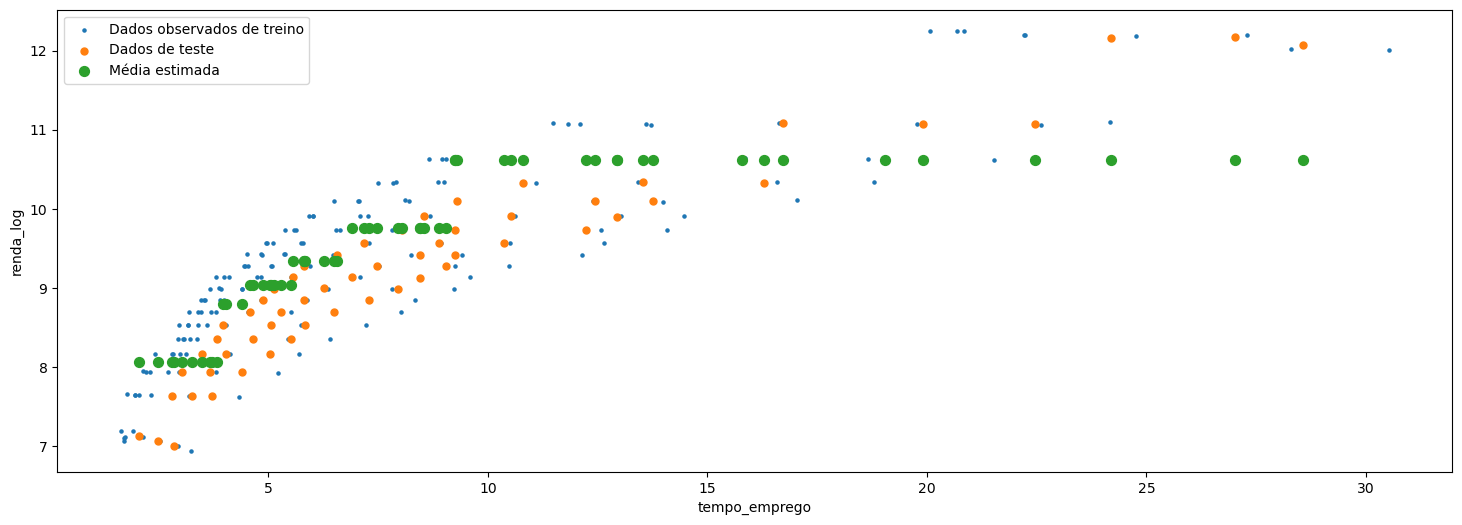

In [126]:
def plotar_resultados_teste(modelo: sm.regression.linear_model.RegressionResultsWrapper) -> None:
    
    plt.figure(figsize=(18,6))
    plt.scatter(df_train_.tempo_emprego, df_train_.renda_log, s=5, label='Dados observados de treino')
    plt.scatter(df_test_.tempo_emprego, df_test_.renda_log, s=25, label='Dados de teste')
    plt.scatter(df_test_.tempo_emprego, modelo.predict(df_test_), s=50, label='Média estimada')
    plt.xlabel(xlabel='tempo_emprego')
    plt.ylabel(ylabel='renda_log')
    plt.legend(loc=2)
    plt.show()
    

plotar_resultados_teste(modelo=cat_model)


R-quadrado ajustado do modelo: 79.54%
R-quadrado com dados de teste: 84.22%



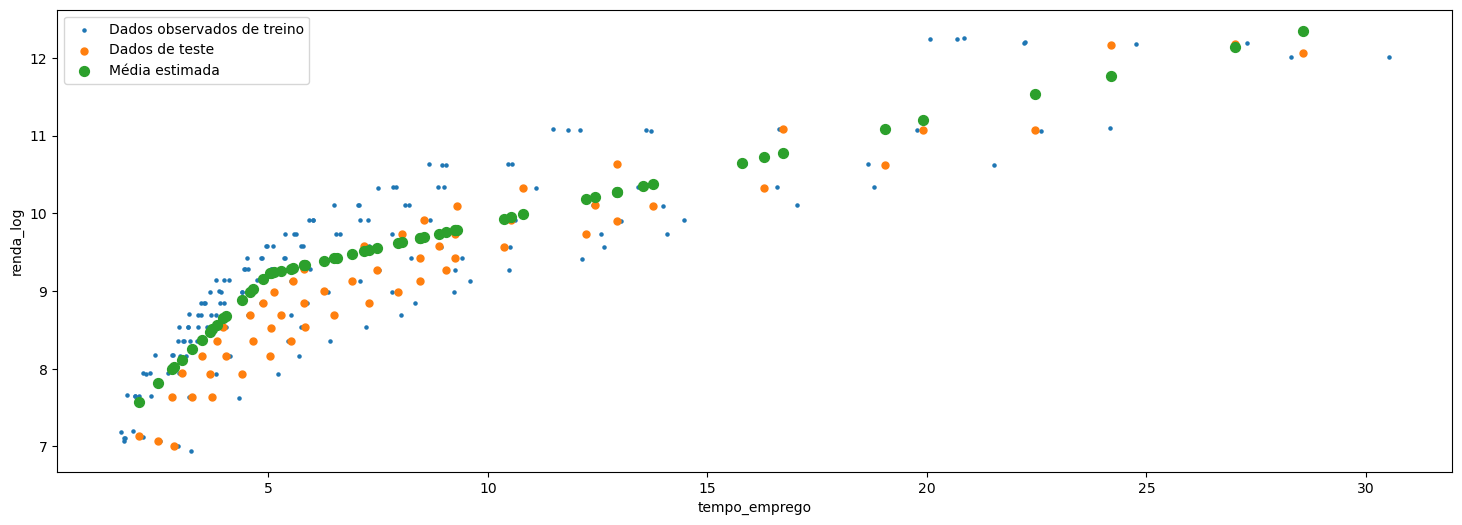

In [127]:
C1 = 5

df_train_['X_1'] = (df_train_['tempo_emprego'] <= C1) * df_train_['tempo_emprego'] + (df_train_['tempo_emprego'] >  C1) * C1
df_train_['X_2'] = (df_train_['tempo_emprego'] >  C1) * df_train_['tempo_emprego'] + (df_train_['tempo_emprego'] <= C1) * C1

df_test_['X_1'] = (df_test_['tempo_emprego'] <= C1) * df_test_['tempo_emprego'] + (df_test_['tempo_emprego'] >  C1) * C1
df_test_['X_2'] = (df_test_['tempo_emprego'] >  C1) * df_test_['tempo_emprego'] + (df_test_['tempo_emprego'] <= C1) * C1

modelo_segmentado = smf.ols(formula='renda_log ~ X_1 + X_2', data=df_train_).fit()

print(f'''
R-quadrado ajustado do modelo: {segmented_model.rsquared_adj:.2%}
R-quadrado com dados de teste: {r2_score(y_true=df_test_.renda_log, y_pred=segmented_model.predict(df_test_)):.2%}
''')

plotar_resultados_teste(modelo=modelo_segmentado)

In [128]:
# Calculando LOWESS para os dados de treinamento
lowess_ = sm.nonparametric.lowess(endog=df_train_.renda_log, exog=df_train_.tempo_emprego, frac=2/3)

f_ = interp1d(x=lowess_[:,0], y=lowess_[:,1], bounds_error=False)

df_train_['lowess'] = f_(df_train_.tempo_emprego)
df_test_['lowess'] = f_(df_test_.tempo_emprego)

mod_lowess = smf.ols(formula='renda_log ~ lowess', data=df_train_).fit()

print(f'''
R-quadrado ajustado do modelo: {lowess_model.rsquared_adj:.2%}
R-quadrado com dados de teste: {r2_score(y_true=df_test_.renda_log, y_pred=lowess_model.predict(df_test_)):.2%}
''')

plotar_resultados_teste(modelo=mod_lowess)


R-quadrado ajustado do modelo: 79.74%
R-quadrado com dados de teste: 85.10%

